In [1]:
import requests
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# API link
api_prefix = "https://api.punkapi.com/v2/"

# Get data on all beers
resp = requests.get(api_prefix + "beers")

# Convert to json
beer = resp.json()

In [3]:
# Create network graph
g=nx.Graph()

# Create a dataframe
df = pd.DataFrame(beer)

df.head()

,id,name,tagline,first_brewed,description,image_url,abv,ibu,target_fg,target_og,...,srm,ph,attenuation_level,volume,boil_volume,method,ingredients,food_pairing,brewers_tips,contributed_by
0,1,Buzz,A Real Bitter Experience.,09/2007,"A light, crisp and bitter IPA brewed with Engl...",https://images.punkapi.com/v2/keg.png,4.5,60.0,1010,1044.0,...,10.0,4.4,75.0,"{'value': 20, 'unit': 'litres'}","{'value': 25, 'unit': 'litres'}","{'mash_temp': [{'temp': {'value': 64, 'unit': ...","{'malt': [{'name': 'Maris Otter Extra Pale', '...","[Spicy chicken tikka masala, Grilled chicken q...",The earthy and floral aromas from the hops can...,Sam Mason <samjbmason>
1,2,Trashy Blonde,You Know You Shouldn't,04/2008,"A titillating, neurotic, peroxide punk of a Pa...",https://images.punkapi.com/v2/2.png,4.1,41.5,1010,1041.7,...,15.0,4.4,76.0,"{'value': 20, 'unit': 'litres'}","{'value': 25, 'unit': 'litres'}","{'mash_temp': [{'temp': {'value': 69, 'unit': ...","{'malt': [{'name': 'Maris Otter Extra Pale', '...","[Fresh crab with lemon, Garlic butter dipping ...",Be careful not to collect too much wort from t...,Sam Mason <samjbmason>
2,3,Berliner Weisse With Yuzu - B-Sides,Japanese Citrus Berliner Weisse.,11/2015,Japanese citrus fruit intensifies the sour nat...,https://images.punkapi.com/v2/keg.png,4.2,8.0,1007,1040.0,...,4.0,3.2,83.0,"{'value': 20, 'unit': 'litres'}","{'value': 25, 'unit': 'litres'}","{'mash_temp': [{'temp': {'value': 60, 'unit': ...","{'malt': [{'name': 'Propino Pale Malt', 'amoun...","[Smoked chicken wings, Miso ramen, Yuzu cheese...",Clean everything twice. All you want is the cl...,Sam Mason <samjbmason>
3,4,Pilsen Lager,Unleash the Yeast Series.,09/2013,Our Unleash the Yeast series was an epic exper...,https://images.punkapi.com/v2/4.png,6.3,55.0,1012,1060.0,...,15.0,4.4,80.0,"{'value': 20, 'unit': 'litres'}","{'value': 25, 'unit': 'litres'}","{'mash_temp': [{'temp': {'value': 65, 'unit': ...","{'malt': [{'name': 'Extra Pale', 'amount': {'v...","[Spicy crab cakes, Spicy cucumber and carrot T...",Play around with the fermentation temperature ...,Ali Skinner <AliSkinner>
4,5,Avery Brown Dredge,Bloggers' Imperial Pilsner.,02/2011,An Imperial Pilsner in collaboration with beer...,https://images.punkapi.com/v2/5.png,7.2,59.0,1027,1069.0,...,5.0,4.4,67.0,"{'value': 20, 'unit': 'litres'}","{'value': 25, 'unit': 'litres'}","{'mash_temp': [{'temp': {'value': 66, 'unit': ...","{'malt': [{'name': 'Lager Malt', 'amount': {'v...","[Vietnamese squid salad, Chargrilled corn on t...",Make sure you have a big enough yeast starter ...,Sam Mason <samjbmason>


In [4]:
# Extract relevant columns
features = ['abv', 'ibu', 'ph']
X_scaled = df[['abv', 'ibu', 'ph']].values

# Normalize the data
scaler = StandardScaler()

In [5]:
# Jaccard Similarity calculations

def jaccard_similarity(beer1, beer2):
    intersection = len(set(beer1) & set(beer2))
    union = len(set(beer1) | set(beer2))
    return intersection / union

def get_top_jaccard_similar_beer(target_beer, k=10):
    similarities = []
    for _, row in df.iterrows():
        if row['name'] != 'Buzz':  # Exclude Pikachu
            similarity = jaccard_similarity(target_beer, row[features])
            similarities.append((row['name'], similarity))
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:k]

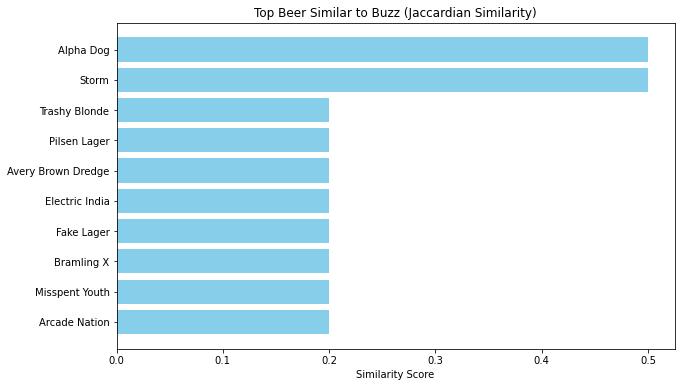

In [6]:
# Visual representaton of Jaccard similarity 
beer_stats = df[df['name'] == 'Buzz'][['abv', 'ibu', 'ph']].values[0].tolist()
top_jaccard_similar = get_top_jaccard_similar_beer(beer_stats)
beer_names = []
similarity_scores = []

for elem in top_jaccard_similar:
    beer_names.append(elem[0])
    similarity_scores.append(elem[1])

plt.figure(figsize=(10, 6))
plt.barh(beer_names, similarity_scores, color='skyblue')
plt.xlabel('Similarity Score')
plt.title('Top Beer Similar to Buzz (Jaccardian Similarity)')
plt.gca().invert_yaxis()
plt.show()

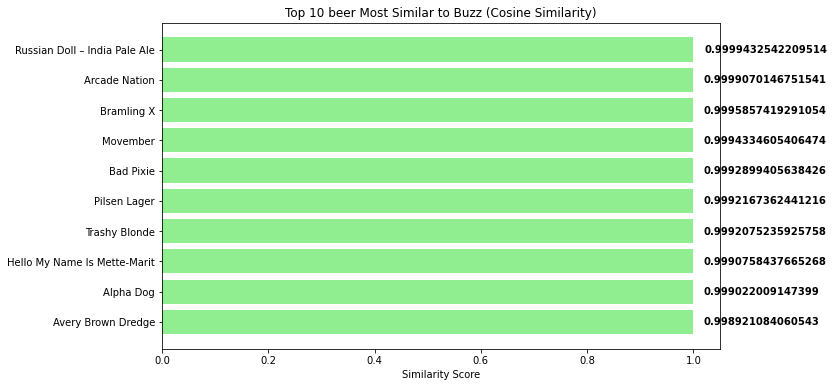

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming df and X_scaled are defined earlier in your code

def get_top_cosine_similar_beer(target_beer, k=10):
    similarities = []
    for i, row in df.iterrows():
        # Ensure the target beer and the row in the dataset are valid for comparison
        if row['name'] != 'Buzz' and np.isfinite(X_scaled[i]).all(): 
            # Handling NaN values in target_beer if necessary
            target_beer_processed = np.nan_to_num(target_beer)
            cosine_similarities = cosine_similarity([target_beer_processed], [X_scaled[i]])
            similarities.append((row['name'], cosine_similarities[0][0]))
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:k]

# Correct the order of usage
top_cosine_similar = get_top_cosine_similar_beer(beer_stats)

beer_names = []
similarity_scores = []

for elem in top_cosine_similar:
    beer_names.append(elem[0])
    similarity_scores.append(elem[1])

plt.figure(figsize=(10, 6))
plt.barh(beer_names, similarity_scores, color='lightgreen')
plt.xlabel('Similarity Score')
plt.title('Top 10 beer Most Similar to Buzz (Cosine Similarity)')

for i, v in enumerate(similarity_scores):
    plt.text(v + 0.02, i, str(v), color='black', va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.show()

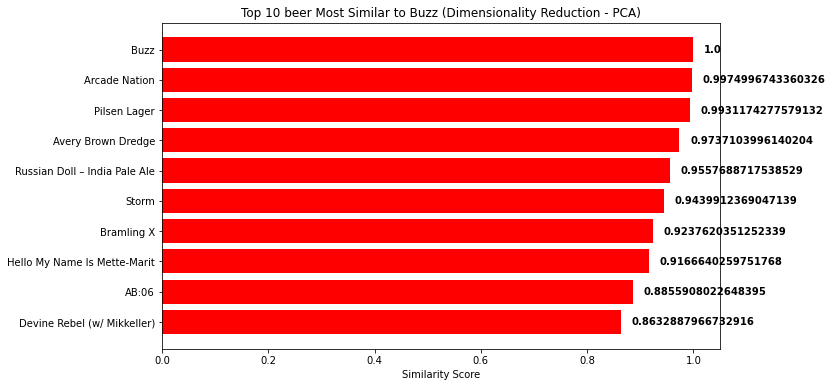

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming df, X_scaled, and beer_stats are defined earlier in your code

def get_top_pca_similar_beer(target_beer, k=10):
    # Handling NaN and Infinite values in X_scaled
    X_scaled_cleaned = np.nan_to_num(X_scaled)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled_cleaned)
    
    # Handling NaN values in target_beer if necessary
    target_beer_processed = np.nan_to_num(target_beer)
    target_pca = pca.transform([target_beer_processed])

    similarities = cosine_similarity(target_pca, X_pca)
    similar_indices = similarities.argsort()[0][::-1][:k]
    return [(df.iloc[i]['name'], similarities[0][i]) for i in similar_indices]


top_pca_similar = get_top_pca_similar_beer(beer_stats)
beer_names = []
similarity_scores = []

for elem in top_pca_similar:
    beer_names.append(elem[0])
    similarity_scores.append(elem[1])

plt.figure(figsize=(10, 6))
plt.barh(beer_names, similarity_scores, color='red')
plt.xlabel('Similarity Score')
plt.title('Top 10 beer Most Similar to Buzz (Dimensionality Reduction - PCA)')

for i, v in enumerate(similarity_scores):
    plt.text(v + 0.02, i, str(v), color='black', va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.show()

In [9]:
top_pca_similar = get_top_pca_similar_beer(beer_stats)

print("Top 10 beer most similar to Buzz using Jaccardian Similarity:")
for elem in top_jaccard_similar:
    print(elem)

print("\nTop 10 beer most similar to Buzz using Cosine Similarity:")
for elem in top_cosine_similar:
    print(elem)

print("\nTop 10 beer most similar to Buzz using Dimensionality Reduction (PCA):")
for elem in top_pca_similar:
    print(elem)

Top 10 beer most similar to Buzz using Jaccardian Similarity:
('Alpha Dog', 0.5)
('Storm', 0.5)
('Trashy Blonde', 0.2)
('Pilsen Lager', 0.2)
('Avery Brown Dredge', 0.2)
('Electric India', 0.2)
('Fake Lager', 0.2)
('Bramling X', 0.2)
('Misspent Youth', 0.2)
('Arcade Nation', 0.2)

Top 10 beer most similar to Buzz using Cosine Similarity:
('Russian Doll – India Pale Ale', 0.9999432542209514)
('Arcade Nation', 0.9999070146751541)
('Bramling X', 0.9995857419291054)
('Movember', 0.9994334605406474)
('Bad Pixie', 0.9992899405638426)
('Pilsen Lager', 0.9992167362441216)
('Trashy Blonde', 0.9992075235925758)
('Hello My Name Is Mette-Marit', 0.9990758437665268)
('Alpha Dog', 0.999022009147399)
('Avery Brown Dredge', 0.998921084060543)

Top 10 beer most similar to Buzz using Dimensionality Reduction (PCA):
('Buzz', 1.0)
('Arcade Nation', 0.9974996743360326)
('Pilsen Lager', 0.9931174277579132)
('Avery Brown Dredge', 0.9737103996140204)
('Russian Doll – India Pale Ale', 0.9557688717538529)
('Stor